# Live Coding Session 3 - General Purpose Algorithms

## Outline

* Clustering
* Network Flow
* Matchings

## Installation

#### Terminal
```bash
git clone https://github.com/libklein/mfms-ss21
cd mfms-ss21
pip install -r requirements.txt
jupyter notebook
```

#### PyCharm
```bash
Download git repo
Open project in pycharm
```

#### [Binder](https://github.com/libklein/mfms-ss21)

In [ ]:
import networkx as nx
import random
from matplotlib import pyplot as plt
from math import sqrt
from funcy import *
from itertools import product
from typing import Optional, Tuple, Sequence, Dict, List, Any, TypeVar, Callable
Point = Tuple[float, float]
def distance(origin: Point, dest: Point) -> float:
    return sqrt((origin[0] - dest[0])**2 + (origin[1] - dest[1])**2)

In [ ]:
def plot(points, centroids, clusters=None, *args, **kwargs):
    if clusters is not None:
        labels = [next(c_id for c_id, c in enumerate(clusters) if point in c) for point in points]
        cluster_colors = [f'C{c_id}' for c_id in range(len(clusters))]
    else:
        labels = [0 for _ in points]
        cluster_colors = ['b']

    plt.scatter(x=[x for x,y in points], y=[y for x,y in points], c=[cluster_colors[l] for l in labels], *args, **kwargs)
    if len(centroids) > 0:
        plt.scatter(x=[x for x,y in centroids], y=[y for x,y in centroids], c=cluster_colors if clusters else 'r', marker='x', *args, **kwargs)
    plt.show()

## Clustering

Group data together based on a distance metric:

$$ variance(C) = \sum_{c \in C} distance(\mu_C, c)^2 $$
$$ dissimilarity(C) = \sum_{c \in C} variance(C) $$

* Use-cases (transportation):
    * Preprocessing
    * Facility locations (LRP)
    * Ride pooling, grouping, ...
* Use-cases (general):
    * Redundancy elimination
    * Unsupervised learning (classification)

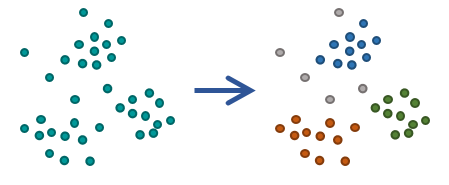

### Algorithms

* Many approaches

We will consider:

### Hierarchical clustering

### K-Means

### Hierarchical Clustering (agglomerative)

```
1. Start with clusters of size 1
Until termination criterion met:
2. Merge the two clusters with the least distance
```

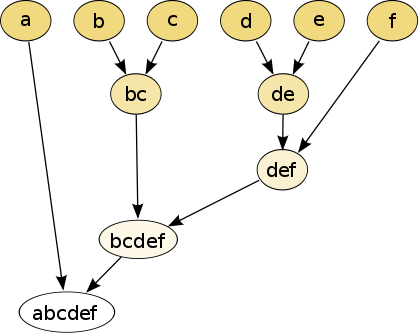

**Useful termination criteria?**

* Number of clusters
* Distance threshold

**How do we define the distance between two clusters?**

### Linkage Metrics

* **Single-linkage**: Shortest distance between any two points of clusters $C_1, C_2$.

* **Complete-linkage**:  Greatest distance between any two points of clusters $C_1, C_2$.

* **Average-linkage**: Average of all pairwise distances between $c_1 \in C_1$ and $c_2 \in C_2$

* **Ward**: Minimize the total within-cluster variance over all clusters

### Implementation

In [ ]:
Cluster = List[List[Point]]
def single_linkage(c_1: Cluster, c_2: Cluster) -> float:
    return min(distance(p_1, p_2) for p_1, p_2 in product(c_1, c_2))

def complete_linkage(c_1: Cluster, c_2: Cluster) -> float:
    pass

In [ ]:
def agglomerative_clustering(data: Sequence[Point], get_distance: Callable[[Cluster, Cluster], float]) -> List[List[Cluster]]:
    clusters = [[point] for point in data]
    clusters_in_iteration = [clusters[:]]
    while len(clusters) > 1:
        # Find closest clusters
        # Initialize the search
        closest_clusters = clusters[0], clusters[1]
        dist = get_distance(*closest_clusters)
        # Calculate distance between all pairs of clusters
        for c_1, c_2 in product(clusters, clusters):
            if c_1 is c_2:
                break
            if (new_distance := get_distance(c_1, c_2)) > get_distance(c_1, c_2):
                dist = new_distance
                closest_clusters = (c_1, c_2)
                    
        c_1, c_2 = closest_clusters
        # Merge them
        # First remove old cluster from the list
        clusters.remove(c_1)
        # And then append all of it's data points to the new cluster
        c_2.extend(c_1)
        #plot(data, [], clusters=clusters)
        # Keep track of clusters in each iteration
        clusters_in_iteration.append(clusters[:])
    return clusters_in_iteration

data = [(random.randint(0, 10), random.randint(0, 10)) for _ in range(7)]
dendogram = agglomerative_clustering(data, single_linkage)

### Final Remarks

* Agglomerative (Bottom-up) clustering
* Divisive (Top-down) clustering

### K-Means

* Perhaps the most well-known clustering algorithm

```
1. k random clusters
Until convergence:
2. Match points to clusters subject to variance minimization
3. Recompute centroids
```

Complexity?

$\mathcal{O}(k \cdot n)$

### Implementation

In [ ]:
# Implement k-means
def k_means(k: int, initial_centroids: Sequence[Point], data: Sequence[Point]) -> Tuple[List[List[Point]], List[Point]]:
    centroids = initial_centroids
    while True:
        updated_clusters = [[] for _ in range(k)]
        # Assign data points
        for point in data:
            closest_centroid = min(((cluster_id, distance(point, centroid)) 
                                   for cluster_id, centroid in enumerate(centroids)), key=lambda x: x[1])[0]
            updated_clusters[closest_centroid].append(point)
        # Recalculate centroids
        updated_centroids = []
        for cluster in updated_clusters:
            updated_centroids.append((sum(x[0] for x in cluster)/len(cluster), sum(x[1] for x in cluster)/len(cluster)))
        if updated_centroids == centroids:
            return updated_clusters, updated_centroids
        centroids = updated_centroids
        
data = [(random.randint(0, 10), random.randint(0, 10)) for _ in range(20)]
k = 3
initial_centroids = [(3,3), (9,7), (4, 9)]
plot(data, initial_centroids)
#clusters, centroids = k_means(k=k, initial_centroids=initial_centroids, data=data)
#plot(data, centroids, clusters=clusters)

### Initialization

K-means is sensitive to the initial cluster locations:

In [ ]:
def objective(clusters: List[List[Point]], centroids: List[Point]) -> float:
    return sum(sum(distance(c, u)**2 for c in cluster) for cluster, u in zip(clusters, centroids))

# Run k_means with randomly choosen initial clusters several times
data = [(random.randint(0, 10), random.randint(0, 10)) for _ in range(20)]
k = 3
for _ in range(5):
    initial_centroids = [(random.randint(0, 10), random.randint(0, 10)) for _ in range(k)]
    try:
        clusters, centroids = k_means(k=k, initial_centroids=initial_centroids, data=data)
    except:
        pass
    print(objective(clusters, centroids))

**How to improve stability?**

### Improving stabiltiy

Ideas:

* Sampling
    * Try several initial cluster locations
    * Clever way of updating guesses?
* Seeding
    * Try to guess good initial cluster locations
    * Potentially uses domain knowledge
    * Often combined with sampling approach

In [ ]:
# Test your ideas
def generate_initial_clusters(k: int, data: Sequence[Point]) -> List[Point]:
    pass

data = [(random.randint(0, 10), random.randint(0, 10)) for _ in range(20)]
k = 3
for _ in range(5):
    initial_centroids = generate_initial_clusters(k=k, data=data)
    try:
        clusters, centroids = k_means(k=k, initial_centroids=initial_centroids, data=data)
    except:
        pass
    print(objective(clusters, centroids))

### K-means++

* Most widely used algorithm to compute initial clusters

```
1. Choose a random data point as first cluster centroid
while |centers| < k:
2. Compute distance D(x, u_c) to closest centroid c for each data point not yet choosen
3. Draw random data point proportial to D(c, u_c)^2
4. Return centers
```

### Choice of k

Ideas?

* A-priori knowlege / constraint
    * 10 customers in our dataset
    * Money to open 4 facilities
* Brute force
* Hierarchicial clustering on subset of data

**No *optimal* strategy**

### Comparison

**K-Means:**

* Fast
* Robust (w.r.t. outliers)
* Initialization
* Choice of k

**Hiearchical:**

* Termination criteria
* Compatibility matrix
* Dendogram
* Determinisitic
* Sensitive to outliers
* Does not scale ($\mathcal{O}(N^3$))

When to use what?

### Libraries

* [Scikit learn](https://https://scikit-learn.org/stable/modules/clustering.html) <- Recommended
* [Scipy](https://docs.scipy.org/doc/scipy/reference/cluster.html)

**Example**:

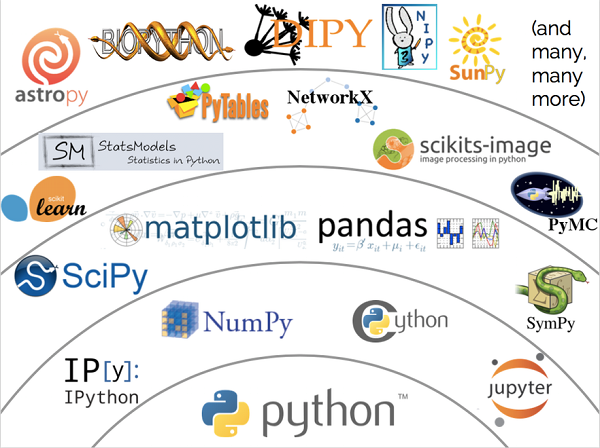

In [ ]:
# Use Scikit learn
from sklearn.cluster import KMeans

data = [(random.randint(0, 10), random.randint(0, 10)) for _ in range(20)]
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
display(kmeans.labels_)
display(kmeans.cluster_centers_)

### Clustering algorithms

| Method name                                              | Parameters                                                       | Scalability                                                                           | Usecase                                                                                 | Geometry (metric used)                       |
|----------------------------------------------------------|------------------------------------------------------------------|---------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|----------------------------------------------|
| `K-Means`                                      | number of clusters                                               | Very large `n_samples`, medium `n_clusters` with `MiniBatch` code | General-purpose, even cluster size, flat geometry, not too many clusters, inductive     | Distances between points                     |
| `Affinity propagation`            | damping, sample preference                                       | Not scalable with n_samples                                                           | Many clusters, uneven cluster size, non-flat geometry, inductive                        | Graph distance (e.g. nearest-neighbor graph) |
| `Mean-shift`                                | bandwidth                                                        | Not scalable with `n_samples`                                                         | Many clusters, uneven cluster size, non-flat geometry, inductive                        | Distances between points                     |
| `Spectral clustering`              | number of clusters                                               | Medium `n_samples`, small `n_clusters`                                                | Few clusters, even cluster size, non-flat geometry, transductive                        | Graph distance (e.g. nearest-neighbor graph) |
| `Ward hierarchical clustering` | number of clusters or distance threshold                         | Large `n_samples` and `n_clusters`                                                    | Many clusters, possibly connectivity constraints, transductive                          | Distances between points                     |
| `Agglomerative clustering`     | number of clusters or distance threshold, linkage type, distance | Large `n_samples` and `n_clusters`                                                    | Many clusters, possibly connectivity constraints, non Euclidean distances, transductive | Any pairwise distance                        |
| `DBSCAN`                                        | neighborhood size                                                | Very large `n_samples`, medium `n_clusters`                                           | Non-flat geometry, uneven cluster sizes, transductive                                   | Distances between nearest points             |
| `OPTICS`                                        | minimum cluster membership                                       | Very large `n_samples`, large `n_clusters`                                            | Non-flat geometry, uneven cluster sizes, variable cluster density, transductive         | Distances between points                     |
| `Gaussian mixtures`                            | many                                                             | Not scalable                                                                          | Flat geometry, good for density estimation, inductive                                   | Mahalanobis distances to centers             |
| `BIRCH`                                          | branching factor, threshold, optional global clusterer.          | Large `n_clusters` and `n_samples`                                                    | Large dataset, outlier removal, data reduction, inductive                               | Euclidean distance between points            |

See [Scikit Learn](https://https//scikit-learn.org/stable/modules/clustering.html)

In [ ]:
def create_random_graph(num_nodes: int, num_edges: Optional[int] = None, avg_edges_per_node: Optional[float] = None):
    num_edges = num_edges if num_edges is not None else int(round(avg_edges_per_node * num_nodes))
    
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    while num_edges > 0:
        origin = random.randint(0, num_nodes-1)
        dest = random.randint(0, num_nodes-1)
        if (origin, dest) in G.edges:
            continue
        G.add_edge(origin, dest)
        num_edges -= 1
    return G

nx.draw(create_random_graph(num_nodes=5, avg_edges_per_node=3), with_labels=True)

## Network Flows

In [ ]:
def plot_network(G, flow=None, print_weight=False):
    pos = {0: (0, 1), 1: (1, 0), 2: (3, 0), 3: (3, 2), 4: (1,2), 5: (4,1)}
    nx.draw_networkx(G, pos=pos)
    if flow is not None:
        edge_labels = {
            (o,d): f'{flow.get(o, {}).get(d, 0)}/{c}' for o,d,c in G.edges.data('capacity')
        }
    else:
        edge_labels = {
            (o,d): c for o, d, c in G.edges.data('capacity')
        }
    nx.draw_networkx_edge_labels(G, pos, label_pos = .5,
                             edge_labels=edge_labels, verticalalignment='top')
    if print_weight:
        nx.draw_networkx_edge_labels(G, pos, label_pos = .5, verticalalignment='bottom',
                             edge_labels={(o,d): f'c: {c}' for o, d, c in G.edges.data('weight')})

    

In [ ]:
def example_graph():
    G = nx.DiGraph()
    G.add_weighted_edges_from([
        (0, 1, 5),
        (0, 4, 8),
        (1, 2, 4),
        (3, 2, 3),
        (4, 2, 5),
        (4, 3, 2),
        (4, 1, 10),
        (2, 5, 6),
        (3, 5, 7)
    ], weight='capacity')
    return G
    
G = example_graph()
plot_network(G)

## Maximum flow

In [ ]:
G = example_graph()
flow_value, flow = nx.maximum_flow(G, 0, 5)
print(f'Found flow of size {flow_value}')
plot_network(G, flow)

### Limitations

`nx.maximum_flow(G, source, sink, capacity, ...)`

* Setting supply/demand not (straightforwardly) possible
* Multiple sources/sinks
* Allows fractional flows

We can get around (some) of these by transforming the network. Ideas?

1. Create dummy source/sink nodes
2. Connect dummy nodes to all sources/sinks with edge capacities according to demand/supply

### Min cost flows

Comes in two flavors:
* `nx.max_flow_min_cost(G, source, sink, capacity, weight) -> FlowDict`
* `nx.min_cost_flow(G, demand, capacity, weight) -> FlowDict`

In [ ]:
G = example_graph()
G.nodes[0]['demand'] = -8
G.nodes[5]['demand'] = 8
nx.set_edge_attributes(G, {e: round(random.uniform(0, 10)) for e in G.edges}, name='weight')
flow = nx.min_cost_flow(G, demand='demand', weight='weight', capacity='capacity')
plot_network(G, flow=flow, print_weight=True)

* Uses network simplex by default
* Slow convergence for fractional values

## Matchings

**What is a matching problem?**
* Maximize the number of pairings such that no object is matched twice

**Formally:**
* Undirected (bipartite) graph $G = (V, E)$
* Subset $M \subseteq E$ of pairwise non-adjacent edges

**Applications:**
* Assignment problems
* Often embedded in "bigger" problems
* Generally:
    * Edges encode "compatibility" relationships
    * Nodes have some sort of "capacity"

### Types of matchings

**Maximal matching**

* Matching $M$ cannot be extended
* No $M' \subseteq E$ such that $M \subset E$

**Maximum matching**

* No bigger matching in $G$
* No $M' \subseteq E$ such that $|M'| > |M|$

**Perfect (complete) matching**

* No unmatched vertices
* $M'$ forms a vertex cover

In [ ]:
G = nx.Graph()
G.add_edges_from([('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'A'), ('C', 'E'), ('E', 'F')])
nx.draw(G, with_labels=True)

### Bipartite graphs

* Comprise two disjoint sets of nodes $A$, $B$
* Edges are only allowed between sets
* Sometimes denoted $G = (A, B, E)$

In [ ]:
from networkx import bipartite
def generate_random_bipartite_graph(n, m, p):
    G = bipartite.generators.random_graph(n=n, m=m, p=p)
    A, B = bipartite.sets(G)
    for v in A:
        G.nodes[v]['bipartite'] = 0
    for v in B:
        G.nodes[v]['bipartite'] = 1
    return G, A, B
G, A, B = generate_random_bipartite_graph(n=3, m=5, p=0.5)
print(G.nodes('bipartite'))
nx.draw(G, with_labels=True)
plt.show()

colors = ['r', 'b']
nx.draw(G, with_labels=True, pos=nx.bipartite_layout(G, A), 
        node_color=[colors[bipartite] for _, bipartite in G.nodes('bipartite')])

### Bipartite Maximum Matching

Given graph $G = (A \cup B, E)$, find a matching of maximum cardinality.

### Example: Ski Lift Paring

**Problem setting:**

* Group of skiers and snowboarders
* T-bar lift
* Lift arrives every 10 seconds, takes 2 minutes

**Constraints:**

* Skiers can only ride with snowboarders and vice versa
* Size difference
* Social preferences

**Objective:**

* Minimize lift time

**Model:**

* $G = (A \cup B, E)$, with skiers $A$ and snowboarders $B$
* Edges $E$ if people can share a lift
* Minimizing lift time reduces to finding a maximum matching in $G$.

---

In [ ]:
G, skiers, snowboarders = generate_random_bipartite_graph(n=3, m=3, p=.5)
nx.draw(G, with_labels=True, pos=nx.bipartite_layout(G, skiers))
plt.close()
# Compute maximum matching
matching = bipartite.maximum_matching(G, top_nodes=skiers)
print(matching)

# Plot it
nx.draw(G, with_labels=True, 
        edge_color=['r' if (o in matching and matching[o] == d) else 'w' for o,d in G.edges],
        pos=nx.bipartite_layout(G, skiers))

### Example: Brown Bag Seminars

**Problem setting:**

* Seminar speaker provides lunch for attendees
* Supplies meals in different quantities
* Students attend only when fed

**Constraints:**

* Dietary preferences
* Number of meals of each type

**Objective:**

* Maximize number of participants (i.e., people who get to each lunch)

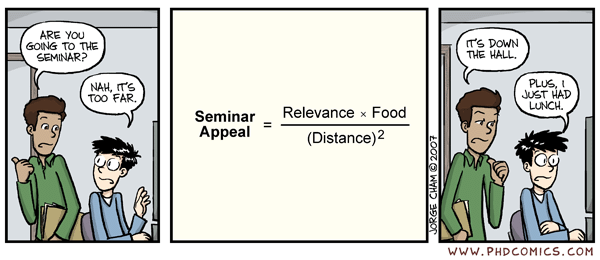

### Weighted Bipartite Matching

* Edges are assigned weights
* Find maximum matching that minimizes the sum of weights 
* Also called *rectangular linear assignment problem*

In [ ]:
# Implementation in network x
G, A, B = generate_random_bipartite_graph(n=3, m=3, p=0.7)
# Set weights
for attrs in G.edges.values():
    attrs['weight'] = round(random.uniform(0.0, G.number_of_edges()), 2)
# Plot graph
pos = nx.bipartite_layout(G, A)
nx.draw_networkx(G, pos=pos)
_ = nx.draw_networkx_edge_labels(G, pos, label_pos = .75,
                             edge_labels={tuple(e): weight for *e, weight in G.edges.data('weight')})

# Compute min-cost matching
matching = nx.bipartite.minimum_weight_full_matching(G, top_nodes=A, weight='weight')
print(matching)

### Non-perfect Weighted Bipartite Matchings

* Also called the *unbalanced assignment problem*
* Ideas?

* Can be reduced to balanced assignment problem:

```
w.l.o.g., |A| > |B|
1. Add |A|-|B| dummy nodes to B
2. Add 0-cost edges between each added vertex in B and all vertices in A to G
3. Solve the resulting minimum weight full matching problem
```

* **`NetworkX` handles non-perfect matching automatically.**